# Introduction

**Name:** Isiah Cruz

**Course:** Flatiron Online Part-Time Data Science

**Project:** Capstone/Final Project

**Date Completed:** December 2020

**Data:** https://data.world/brianray/enron-email-dataset

# I. Importing

In [2]:
from wordcloud import WordCloud
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

from nltk import FreqDist, word_tokenize
from nltk.collocations import *
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from sklearn import metrics, preprocessing
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from imblearn.over_sampling import SMOTE

In [3]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [4]:
def print_metrics(model, x_test, y_test):
    preds = model.predict(x_test)
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds, average='weighted')
    recall = recall_score(y_test, preds, average='weighted')
    f1 = f1_score(y_test, preds, average='weighted')
    print("Accuracy Score for model: {:.4}%".format(accuracy * 100))
    print("Precision Score for model: {:.4}%".format(precision * 100))
    print("Recall Score for model: {:.4}%".format(recall * 100))
    print("F1 Score for model: {:.4}%".format(f1 * 100))
    return accuracy, precision, recall, f1

In [5]:
enron = pd.read_csv('enron.csv') #import and store our dataset in a dataframe

# II. Data Preparation

<font color='blue'>**Now that our data is stored in the 'enron' dataframe, we can go ahead and start examining this dataframe closely.**</font>

## A) EXAMINATION

In [6]:
enron.head(n=5) #preview data

column_a                                     message_id  \
0         0  <18782981.1075855378110.JavaMail.evans@thyme>   
1         1  <15464986.1075855378456.JavaMail.evans@thyme>   
2         2  <24216240.1075855687451.JavaMail.evans@thyme>   
3         3  <13505866.1075863688222.JavaMail.evans@thyme>   
4         4  <30922949.1075863688243.JavaMail.evans@thyme>   

                  date                                    from  \
0  2001-05-14T23:39:00  frozenset({'phillip.allen@enron.com'})   
1  2001-05-04T20:51:00  frozenset({'phillip.allen@enron.com'})   
2  2000-10-18T10:00:00  frozenset({'phillip.allen@enron.com'})   
3  2000-10-23T13:13:00  frozenset({'phillip.allen@enron.com'})   
4  2000-08-31T12:07:00  frozenset({'phillip.allen@enron.com'})   

                                       to    subject           x_from  \
0     frozenset({'tim.belden@enron.com'})        NaN  Phillip K Allen   
1  frozenset({'john.lavorato@enron.com'})        Re:  Phillip K Allen   
2   frozenset({'leah.arsdall@enron.com'})   Re: test  Phillip K Allen   
3    frozenset({'randall.gay@enron.com'})        NaN  Phillip K Allen   
4     frozenset({'greg.piper@enron.com'})  Re: Hello  Phillip K Allen   

                                                x_to x_cc x_bcc  ...  \
0           Tim Belden <Tim Belden/Enron@EnronXGate>  NaN   NaN  ...   
1  John J Lavorato <John J Lavorato/ENRON@enronXg...  NaN   NaN  ...   
2                                   Leah Van Arsdall  NaN   NaN  ...   
3                                      Randall L Gay  NaN   NaN  ...   
4                                         Greg Piper  NaN   NaN  ...   

  cat_10_level_1 cat_10_level_2 cat_10_weight cat_11_level_1 cat_11_level_2  \
0            NaN            NaN           NaN            NaN            NaN   
1            NaN            NaN           NaN            NaN            NaN   
2            NaN            NaN           NaN            NaN            NaN   
3            NaN            NaN           NaN            NaN            NaN   
4            NaN            NaN           NaN            NaN            NaN   

  cat_11_weight  cat_12_level_1  cat_12_level_2  cat_12_weight  labeled  
0           NaN             NaN             NaN            NaN    False  
1           NaN             NaN             NaN            NaN    False  
2           NaN             NaN             NaN            NaN    False  
3           NaN             NaN             NaN            NaN    False  
4           NaN             NaN             NaN            NaN    False  

[5 rows x 52 columns]

<font color='blue'>**A quick look at the data shows that the data seems to be separated into categories (seemingly based on how the data was manually labeled).**</font>

In [7]:
enron['labeled'].value_counts() #count the labeled column

False    515699
True       1702
Name: labeled, dtype: int64

<font color='blue'>**Running value_counts() on our 'labeled' column shows us that only 1702 out of our 500K+ rows are labeled!**</font>

In [8]:
enron['cat_1_level_1'].value_counts() #count the 1st category

True    1702
Name: cat_1_level_1, dtype: int64

<font color='blue'>**Counting the 1st categorized column does not seem to show any specific label other than an indication as to whether the row is unlabeled or labeled. Let's refine our dataset to only include labeled rows:**</font>

In [9]:
df = enron[enron.labeled == True] #include only labeled data in our dataframe
df.shape #examine the size of the dataset

(1702, 52)

<font color='blue'>**It looks like we successfully slimmed down our dataset, as evidenced by the figures returned by df.shape. Now we can take a look at other categorization columns to see if we find anything there.**</font>

In [10]:
df['cat_2_level_1'].value_counts() #count what is contained in the column

2.0    1113
1.0     207
3.0     150
4.0      36
Name: cat_2_level_1, dtype: int64

In [11]:
print(1113+207+150+36) #calculate the sum
print('% of labeled rows in Category 2:',1506/1702) #calculate percentage

1506
% of labeled rows in Category 2: 0.8848413631022327


In [12]:
print(1113/1506)
print(207/1506)
print(150/1506)
print(36/1506)

0.7390438247011952
0.13745019920318724
0.099601593625498
0.02390438247011952


In [13]:
df['cat_3_level_1'].value_counts() #count what is contained in the column

2.0    794
3.0    354
4.0     71
1.0     16
Name: cat_3_level_1, dtype: int64

In [14]:
print(794+354+71+16) #calculate the sum
print('% of labeled rows in Category 2:',1235/1702) #calculate percentage

1235
% of labeled rows in Category 2: 0.7256169212690952


<font color='blue'>**There seems to be a gradual decline as we move from one categorization column to the other, which makes sense since not every email will fit into several categories. Therefore, we can stick with categorization column 2 for the purposes of our analysis since this column has the most labeled data in it.**
    
**Let's take a look at what each label (#1.0-4.0) stands for:**</font>

- 1 Coarse genre (Company strategy, Logistic arrangements, etc)
- 2 Included/forwarded information (Forwarded emails, Press releases, etc)
- 3 Primary topics (Meeting minutes, Regulations, etc)
- 4 Emotional tone (Jubilation, Sarcasm, etc)

In [15]:
df = df[['cat_2_level_1','content']] #revised the dataframe with data from only category 2
df.head(n=3) #preview the data

cat_2_level_1                                            content
379             3.0  I also need to know the base salaries of Jay R...
381             4.0  Thanks for the information. It would be helpfu...
2139            2.0  -----Original Message----- From: Hawkins, Bern...

<font color='blue'>**Now that we have slimmed out dataset to a label column and a content column, we can remove null values and duplicates.**</font>

In [16]:
df.isna().sum() #check for null values

cat_2_level_1    196
content            5
dtype: int64

<font color='blue'>**We have 201 null values that we can remove right away.**</font>

In [17]:
df = df.dropna() #drop all rows with null values

<font color='blue'>**Next we can check for dupes.**</font>

In [18]:
dups = df['content'].duplicated() #checking for duplicates
print(dups.value_counts())

False    1398
True      103
Name: content, dtype: int64


In [19]:
df = df.drop_duplicates(subset=['content']) #drop duplicates

<font color='blue'>**We have removed our duplicates so we can close by renaming our columns to something more simplified and easy to use.**</font>

In [20]:
df = df.rename(columns={'cat_2_level_1': 'labeled'}) #rename the column
df

labeled                                            content
379         3.0  I also need to know the base salaries of Jay R...
381         4.0  Thanks for the information. It would be helpfu...
2139        2.0  -----Original Message----- From: Hawkins, Bern...
2140        2.0  -----Original Message----- From: Perrino, Dave...
2232        2.0  -----Original Message----- From: Comnes, Alan ...
...         ...                                                ...
499650      2.0  There is a lot of confidential information her...
501042      2.0  You may have seen this when it first came out ...
507376      2.0  Mark, Can you email me or fax me any written d...
509660      2.0  To:WILLIAMS, WILLIAM Email:bwillia5@enron.com ...
511979      2.0  You have to love the availability of beautiful...

[1398 rows x 2 columns]

## B) OUTLIERS

<font color='blue'>**Our final step of data cleaning is to remove any outliers that may skew our analysis. For email classification in NLP, a great place to start is by counting the number of words in each email.**</font>

In [21]:
df['word_count'] = df['content'].apply(lambda x: len(str(x).split())) #create a column that counts words

In [22]:
df.insert(0, 'id', range(0, 0 + len(df))) #add an ID column

In [23]:
df.sort_values(by=['word_count'], ascending=False) #sort in descending order

id  labeled                                            content  \
260211  1176      2.0  Rival to Buy Enron, Top Energy Trader, After F...   
58523     89      2.0  Today's News....Thanks - Jean Wall Street Jour...   
61047    122      2.0  Please see the following articles: Sac Bee, We...   
57414     75      2.0  Today's news, and some from the weekend, in th...   
158166   202      2.0  Please see the following articles: AP Wire ser...   
...      ...      ...                                                ...   
38949     23      2.0                                         Here it is   
56573     60      4.0                                              Amen.   
221863   278      2.0                               http://www.ssrn.com/   
221983   377      2.0                           http://www.vaionline.it/   
227636   447      2.0                                           Skilling   

        word_count  
260211       37114  
58523        32676  
61047        29453  
57414        29060  
158166       27020  
...            ...  
38949            3  
56573            1  
221863           1  
221983           1  
227636           1  

[1398 rows x 4 columns]

<font color='blue'>**As we can see in the chart above, some of our emails have 25K+ words, while others have 3 words. This hints that our dataset has outliers, but let's visualize it in the form of a boxplot to be sure.**</font>

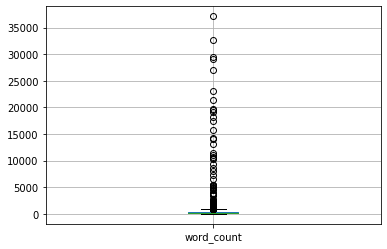

In [24]:
df.boxplot(['word_count']) #visualize the distribution of the column

<font color='blue'>**The boxplot clearly shows that we have a good deal of outliers. Let's use IQR to make our dataset more evenly distributed.**</font>

In [25]:
df2 = df.drop(columns=['labeled','content']) #drop columns

In [26]:
Q1 = df2.quantile(0.25)
Q3 = df2.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

#split the new dataset into quantiles and calculate IQR

id            698.5
word_count    307.5
dtype: float64


<font color='blue'>**The boxplot clearly shows that we have a good deal of outliers. Let's use IQR to make our dataset more evenly distributed.**</font>

In [27]:
df2 = df2[~((df2 < (Q1 - 1.5 * IQR)) |(df2 > (Q3 + 1.5 * IQR))).any(axis=1)] #remove the outliers using IQR

In [28]:
df2.sort_values(by=['word_count'], ascending=False) #sort in descending order

id  word_count
229638   771         867
48342     30         849
228257   617         846
435040  1272         839
229971   846         839
...      ...         ...
38949     23           3
221983   377           1
56573     60           1
227636   447           1
221863   278           1

[1250 rows x 2 columns]

<font color='blue'>**The IQR methodology seems to have worked since out longest email is now only 867 words long. We can we can now merge back these columns with the updated word count restrictions.**</font>

In [29]:
df3 = df.drop(columns=['word_count']) #create a new datset set without the outlier-free columns

In [30]:
df = pd.merge(df2, df3, on='id', how='inner') #merge our 2 datasets with 'ID' as our index

<font color='blue'>**This means we are officially done with data cleaning and can move on to exploring and visualizing our data.**</font>

# III. Exploratory Data Analysis

<font color='blue'>**A great place to start exploring our data is to remove superfluous words (stopwords), numbers (stopwords & regex), and invlectional affixes (stemmer), that way we can derive meaning from our text data at a high level.**</font>

## A)  TOKENIZATION & STOPWORDS REMOVAL

In [31]:
stop_words = stopwords.words('english') #instantiate stopwords
stop_words += ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'] # add to stopwords
stemmer = SnowballStemmer('english') #instantiate SnowballStemmer
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+|From:|To:|cc|Forwarded|forwarded|original|Original|Message|message|sent|pm|am|wednesday|june|20|2001|august"
#add regex expressions


<font color='blue'>**The code above loads in stopwords, a Snowball Stemmer, and regex expressions that we will feed into our preprocessing function next.**</font>

In [32]:
df['content'] = df.content.apply(lambda x: preprocess(x)) #apply function to the content column

In [33]:
content = str(df['content']) #convert the content column to a string

In [34]:
print(content) #print the string

0       also need know base salaries jay reitmeyer mon...
1       thanks information would helpful would send de...
2       hawkins bernadette 9 59 walton steve mara susa...
3       perrino dave hawkins bernadette walton steve m...
4       comnes alan 1 34 alvarez ray walton steve mara...
                              ...                        
1245    h v e r n u n news advisory september 27 immed...
1246    lot confidential information items 1and 2 deta...
1247    mark email fax written documentation give heid...
1248    willi willi email bwillia5 503 464 3730 enron ...
1249    love availability beautiful lasses viewing thi...
Name: content, Length: 1250, dtype: object


<font color='blue'>**Now that we have refined our text data, we can start to tokenize it as well that way we can analyze it some more.**</font>

In [37]:
tokenizer = nltk.tokenize.word_tokenize(content) #tokenize the string

## B) FREQUENCY DISTRIBUTION

<font color='blue'>**One of the neat tools we can use with our tokenized text data is Frequency Distribution, which allows us to plot the words that are showing up most commonly in our dataset.**</font>

In [35]:
fdist = nltk.FreqDist(tokenizer) #pull frequency distribution

In [36]:
fdist.most_common(10) #diplay the 10 most freqent words

[('...', 11),
 ('walton', 3),
 ('steve', 3),
 (':', 3),
 ('1', 2),
 ('information', 2),
 ('would', 2),
 ('2', 2),
 ('hawkins', 2),
 ('bernadette', 2)]

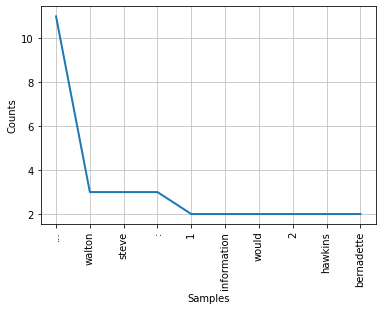

In [37]:
fdist.plot(10) #plot the function

<font color='blue'>**As evidence by the plot above, certain names seem to be popping up quite frequently. For instance, the name "Walton" shows up 3 times — likely referring to David Walton, the class action lawyer who took down Enron for accounting fraud.**</font>

[More on David Walton](https://riabiz.com/a/2016/3/30/the-odd-logic-enron-lawyers-are-relying-on-to-sue-lpl-financial-for-securities-fraud-logic-thats-attracted-five-potential-copycat-investigations-in-10-days)

## C) WORDCLOUD

<font color='blue'>**To continue, we can create a WordCloud that shows gives us an idea of the most frequent/important words across the different labels we use.**</font>

### 1. COARSE GENRE

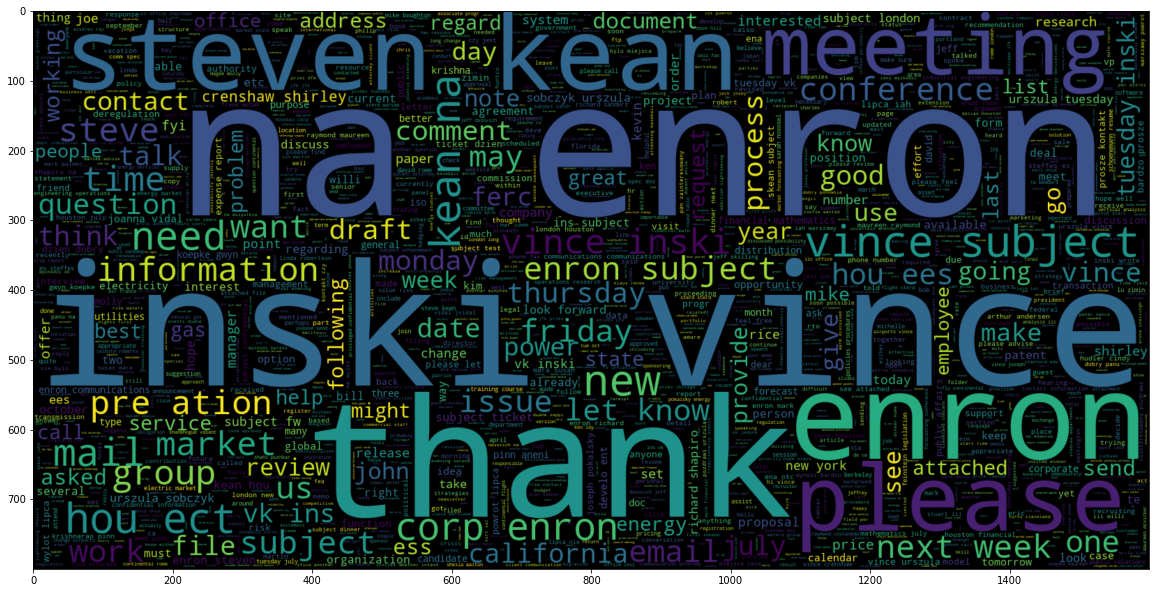

In [770]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.labeled == 1.0].content))
plt.imshow(wc , interpolation = 'bilinear')
#create a wordcloud for rows labeled with 1.0

<font color='blue'>**For those emails labeled with 1.0 (Coarse Genre), it seems that a few names (Vince Kaminski & Steven Kean) and common business logistics terms (conference, draft, meeting, mail, time, subject, etc) stick out.**</font> 
    
<font color='blue'>**This makes sense given that this categorization is largely business & logistics related. Futhermore, it seems that Kaminski (Former Head of Risk Management at Enron) and Kean (Former Chief of Staff at Enron) were sort of internal whistleblowers at the company, which explains why they show up so much in this categorization!**</font>

[More on Kaminski](https://www.oilholicssynonymous.com/2014/01/notes-on-scandal-from-ex-enron.html)

[More on Kean](https://www.nbcnews.com/id/wbna3606477)

### 2. FORWARDED/INCLUDED

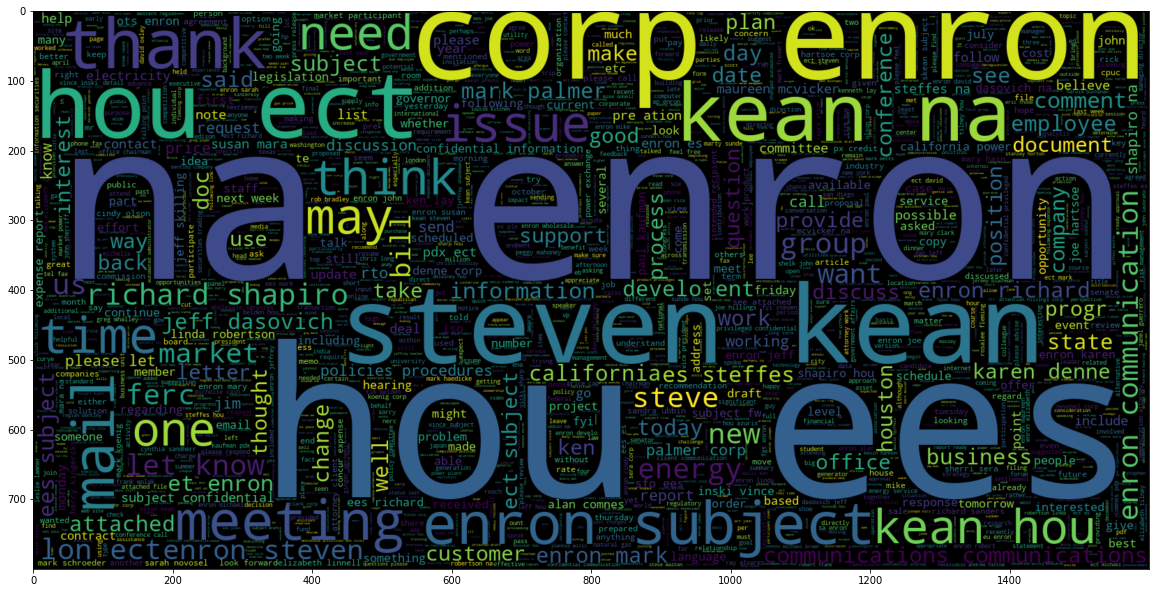

In [771]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.labeled == 2.0].content))
plt.imshow(wc , interpolation = 'bilinear')
#create a wordcloud for rows labeled with 2.0

<font color='blue'>**The WordCloud for category 2.0 (Included/Forwarded information) suggests that much of the forwarded emails between internal employees revolved around what others (like the state of California) "said" about Enron Energy Services (EES). This likely consisted of press releases around the California partires that sued Enron for market manipulation and price gouging.**</font>

[More on the Energy Crisis Settlement](https://oag.ca.gov/news/press-releases/attorney-general-lockyer-announces-energy-crisis-settlement-enron-valued-152)

### 3. PRIMARY TOPICS

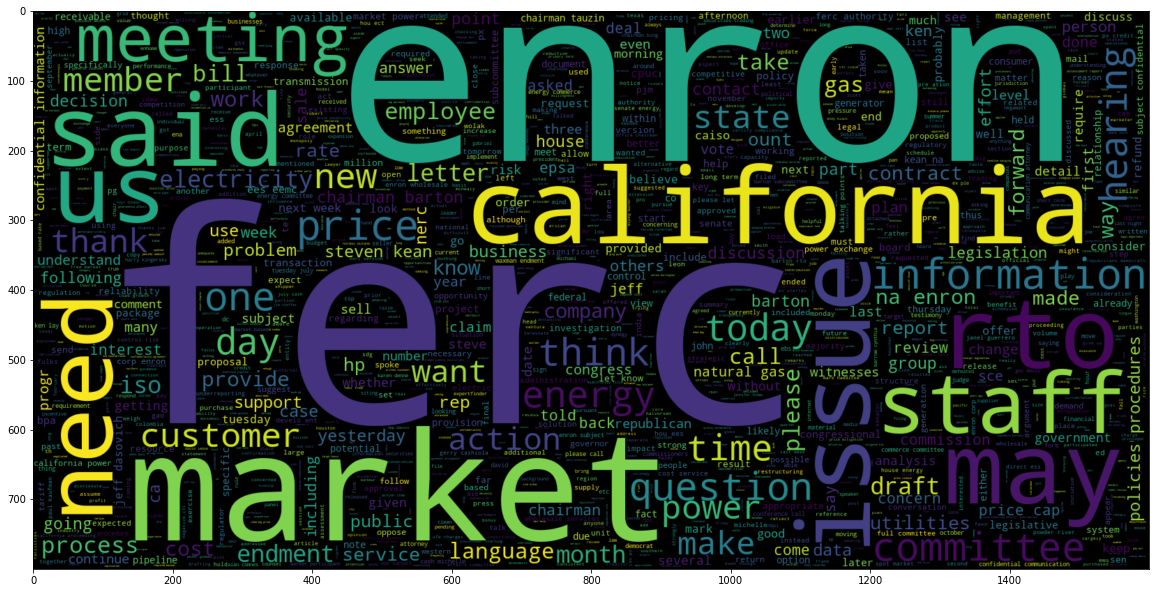

In [772]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.labeled == 3.0].content))
plt.imshow(wc , interpolation = 'bilinear')
#create a wordcloud for rows labeled with 3.0

<font color='blue'>**Again, we see that category 3.0 (Primary topics) centers around the issue at the heart of the scandal - which was the exorbitant prices charged to Californian ratepayer in 2000. This is evidenced by the prominence of words like "electricity", "power", "energy", "rate", "price", "bill", and more.**</font>

### 4. EMOTIONAL TONE

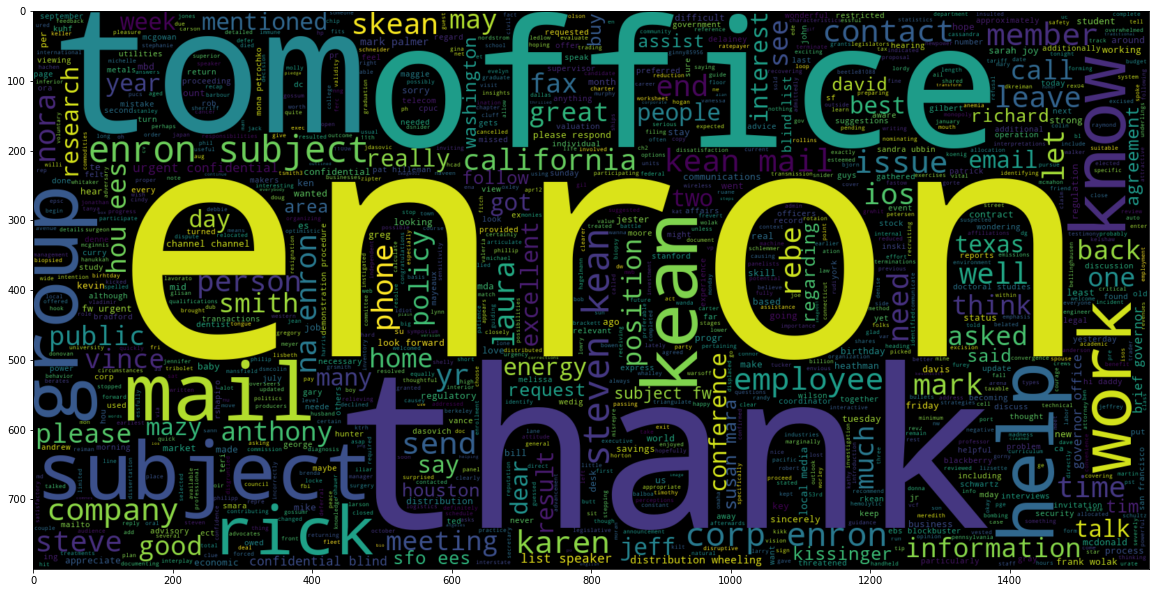

In [773]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.labeled == 4.0].content))
plt.imshow(wc , interpolation = 'bilinear')
#create a wordcloud for rows labeled with 4.0

<font color='blue'>**Our final categorization 4.0 (Emotional tone) suggests that there was a lot of emotion around the topic of the company (Enron), the office, and "tom" (presumbly Thomas White the former Vice Chairman of Enron Energy Services.**</font>

## D) LABELS

<font color='blue'>**Done with our WordClouds, we can take a look at the distribution of labels across our dataset.**</font>

In [774]:
label_count = pd.DataFrame(df.labeled.value_counts()) #create a dataframe
label_count.reset_index(inplace=True) #reset the index
label_count.columns = ["labels", "count"] #create new columns

Text(0, 0.5, 'Count')

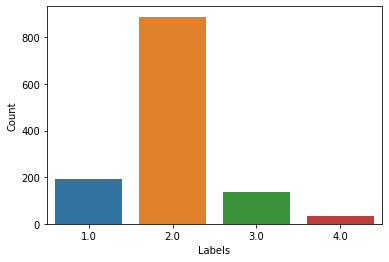

In [775]:
sns.barplot(y="count", x="labels", data=label_count) #plot the label count data
plt.xlabel("Labels") #name the x axis
plt.ylabel("Count") #name the y axis

<font color='blue'>**The graph above tells us 2 important details: 1) Most of our email data consists of emails that were forwarded or included some sort of attachment. This suggests that there was a good amount of internal "gossip" going around as the Enron scandal appeared. 2) We seem to have a class imbalance with our data (where one label vastly overpowers the others), so this is something we will have to address in our modeling stage.**</font>

## E) WORD COUNT

<font color='blue'>**Finally, we can count the length of our emails to get a better sense of how long the typical email is.**</font>

In [776]:
df["word_count"] = df['content'].apply(lambda x: len(str(x).split())) #create a new dataframe & count words

Text(0, 0.5, 'Count')

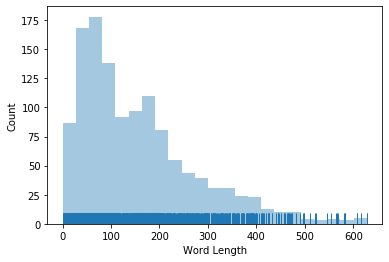

In [777]:
sns.distplot(df.word_count, kde=False, rug=True) #plot the word count data
plt.xlabel("Word Length") #name the x axis
plt.ylabel("Count") #name the y axis

<font color='blue'>**Our distribution plot shows that most of our emails have between 50-200 words in them (which sounds consistent with what one would expect at a fast-paced corporate company in the midst of a scandal).**</font>

<font color='blue'>**Now that we are done with our EDA, we can move to Modeling!**</font>

# IV. Modeling

<font color='blue'>**We can start our model by loading our training and testing data.**</font>

## A) TRAIN-TEST-SPLIT

In [35]:
X = df['content'] #load the data
y = df['labeled'] #load the target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) #train test split

## B) TF-IDF VECTORIZER

In [36]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'), max_df = .95, min_df = 2, use_idf=True)
#instantiating the TF-IDF vectorizer

In [37]:
X_train = tfidf.fit_transform(X_train) #transform the data using tfidf
X_test = tfidf.transform(X_test) #transform the data using tfidf

<font color='blue'>**Next, we run a TF-IDF Vectorizer which tokenizes our text document, removes words that appear in more than 95% of emails, and removes words that appears less than twice across all emails.**</font>

## C) MULTINOMIAL NAIVE BAYES -- BASELINE MODEL

Train Accuracy: 0.7342582710779082
Test Accuracy: 0.7188498402555911


Accuracy Score for model: 71.88%
Precision Score for model: 69.06%
Recall Score for model: 71.88%
F1 Score for model: 61.52%


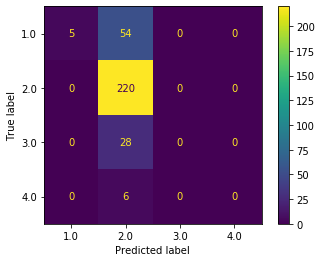

In [38]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

print(f'Train Accuracy: {mnb.score(X_train, y_train)}')
print(f'Test Accuracy: {mnb.score(X_test, y_test)}')
print('\n')

plot_confusion_matrix(mnb, X_test, y_test,values_format=".4g")
mnb_metrics = print_metrics(mnb, X_test, y_test)

## D) CLASS IMBALANCE

In [39]:
print(y_train.value_counts()) #print original class distribution

sm = SMOTE()

X_train_resampled, y_train_resampled = sm.fit_sample(X_train, y_train) #fit SMOTE to training data

print('\n') #add spacing
print(pd.Series(y_train_resampled).value_counts()) #preview new sample class distribution

2.0    668
1.0    131
3.0    109
4.0     29
Name: labeled, dtype: int64


4.0    668
3.0    668
2.0    668
1.0    668
Name: labeled, dtype: int64


<font color='blue'>**Like we noticed earlier, category 2.0 presents a clear class imbalance for out dataset. Therefore, we can use SMOTE to balance things out.**</font>

## D) MULTINOMIAL NAIVE BAYES

<font color='blue'>**We start with Multinomial Naive Bayes as our baseline model since the model is great for text classification and multiclass prediction problems like ours. The model is probabilistic and uses integer/fractional counts to make predictions.**</font>

Train Accuracy: 0.9262724550898204
Test Accuracy: 0.6677316293929713


Accuracy Score for model: 66.77%
Precision Score for model: 70.75%
Recall Score for model: 66.77%
F1 Score for model: 67.82%


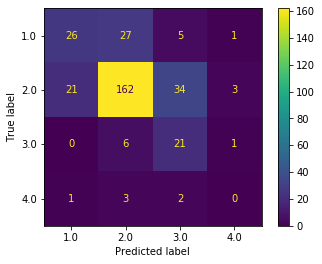

In [40]:
mnb = MultinomialNB()
mnb.fit(X_train_resampled, y_train_resampled)

print(f'Train Accuracy: {mnb.score(X_train_resampled, y_train_resampled)}')
print(f'Test Accuracy: {mnb.score(X_test, y_test)}')
print('\n')

plot_confusion_matrix(mnb, X_test, y_test,values_format=".4g")
mnb_metrics = print_metrics(mnb, X_test, y_test)

<font color='blue'>**Our baseline model using Multinomial Naive Bayes seems to be performing fairly well with a training accuracy score of 67%.**</font>

## E) GRADIENT BOOST

<font color='blue'>**Next, we can use a Gradient Boosting model, an ensemble method model that uses decision trees to sequentially build on our algorithms ability to make predictions. Gradient Boosting actually improves itself as it goes along and is a good fit for classification problems like this one!**</font>

Train Accuracy: 0.9880239520958084
Test Accuracy: 0.7571884984025559


Accuracy Score for model: 75.72%
Precision Score for model: 76.76%
Recall Score for model: 75.72%
F1 Score for model: 75.5%


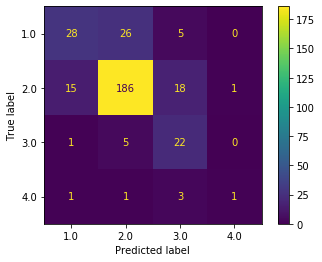

In [44]:
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X_train_resampled, y_train_resampled)

print(f'Train Accuracy: {gb.score(X_train_resampled, y_train_resampled)}')
print(f'Test Accuracy: {gb.score(X_test, y_test)}')
print('\n')

plot_confusion_matrix(gb, X_test, y_test, values_format=".4g")
gb_metrics = print_metrics(gb, X_test, y_test)

<font color='blue'>**Gradient Boosting performed really well for us with an accuracy score of 76%.**</font>

## F) ADABOOST

<font color='blue'>**Moving on, the Adaboost Classifier functions very similarly to Gradient Boost by creating an ensemble of decision trees that all contribute to a final predictive model.**</font>

Train Accuracy: 0.6961077844311377
Test Accuracy: 0.6645367412140575


Accuracy Score for model: 66.45%
Precision Score for model: 67.51%
Recall Score for model: 66.45%
F1 Score for model: 66.32%


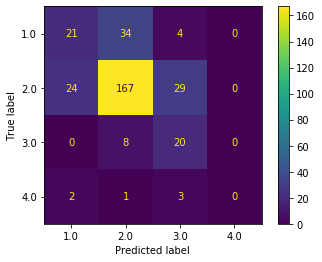

In [45]:
adb = AdaBoostClassifier(n_estimators=100)
adb.fit(X_train_resampled, y_train_resampled)

print(f'Train Accuracy: {adb.score(X_train_resampled, y_train_resampled)}')
print(f'Test Accuracy: {adb.score(X_test, y_test)}')
print('\n')

plot_confusion_matrix(adb, X_test, y_test,values_format=".4g")
adb_metrics = print_metrics(adb, X_test, y_test)

<font color='blue'>**With an accuracy score of 73%, our Adaboost Classifier almost as well as our Gradient Boost model.**</font>

## G) LOGISTIC REGRESSION

<font color='blue'>**Finally, we can try a Logistic Regression model which is also great for text classification.**</font>

Train Accuracy: 0.9723053892215568
Test Accuracy: 0.7284345047923323


Accuracy Score for model: 72.84%
Precision Score for model: 73.34%
Recall Score for model: 72.84%
F1 Score for model: 72.22%


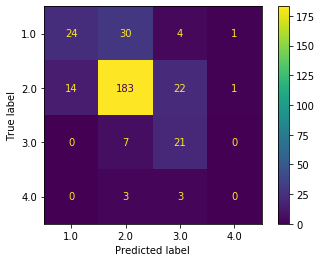

In [43]:
log = LogisticRegression()
log.fit(X_train_resampled, y_train_resampled)

print(f'Train Accuracy: {log.score(X_train_resampled, y_train_resampled)}')
print(f'Test Accuracy: {log.score(X_test, y_test)}')
print('\n')
 
plot_confusion_matrix(log, X_test, y_test,values_format=".4g")
log_metrics = print_metrics(log, X_test, y_test)

<font color='blue'>**With an accuracy score of 74%, our Logistic Regression model comes close to being the best but ultimately falls short of the performance of our Gradient Boosting classifier.**</font>

# V. Conclusion

## A) EVALUATION

<font color='blue'>**Our best model is the Gradient Boosting Classifier:**</font>

In [786]:
gb_metrics = print_metrics(gb, X_test, y_test)

Accuracy Score for model: 76.04%
Precision Score for model: 77.1%
Recall Score for model: 76.04%
F1 Score for model: 75.57%


## B) RECOMMENDATIONS & FUTURE WORK

- **Big Takeaway:** 

Throughout this project, I was able to perform a number of operations that I was able to carry over to a similar dataset for my company NewtonX. For one, the multi-class classification nature of each, means that I was able to select 4 categories from the Enron dataset to mirror the 4 labels present in the NewtonX dataset. In addition, both projects presented outliers when it came to the word length of certain emails that were exorbitantly long (i.e. 37K+ words). Therefore, I was able to use the IQR/outlier-removal tool that I built in the Enron project and directly apply it to the NewtonX one. Finally, both datasets presented a class imbalance, so I was able to use SMOTE to balance things out first on the Enron data and then on the NewtonX data. All in all, I was very intentional about devising the projects in a way that they mirrored each other and that this Enron project allowed me to take useful learnings to the NewtonX one.


- **Next Step #1:**

Use this model to label the 98K or so emails in our original Enron dataset that are unlabeled

- **Next Step #2:**

Apply learnings from this project to the NewtonX project to be able to build a multi-class classification model that predicts the label of a given email. We can then use this classifier model to label emails automatically and create an auto-response tool that responds to emails according the what label they receive.